<a href="https://colab.research.google.com/github/dmoste/DATA608/blob/master/dmoste_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Starting this project was extremely difficult due to the size of the dataset. Upon attempting to open the dataset in spyder, my computer promptly crashed due to lack of available memory. Since I lack experience with Jupyter Notebooks, I chose to use Google Colab to open and work with the data. To do this, I needed to use urllib, io and zipfile to readin the data and open it in a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import io
from zipfile import ZipFile
from urllib.request import urlopen

# Using urllib, zipfile, and io to read in the data set (it was too large for my computer memory to handle)
r = urlopen('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_20v8_csv.zip').read()
file = ZipFile(io.BytesIO(r))
pluto_csv = file.open('pluto_20v8.csv')
nyc = pd.read_csv(pluto_csv, low_memory = False)

# Cleaning and Binning
After reading in the data, the ifrst step was to limit the dataset to the years from 1850 to 2020 and keep only buildings that had non-zero floors. I defined a mins and maxes for binning purposes and then used the cut method from pandas to bin the data. I tried a couple of different binning methods for the number of floors, (linear bins, log bins, and a couple random choices), but ultimately decided to keep the linear binning. I know this isn't the choice that was suggested in the HW, but I thought it created the most useful visual. I did log the observations for each bin though to help witht he display.

In [2]:
# Basic cleaning to get only the desired years and buildings that have more than 0 floors
nyc = nyc[(nyc['yearbuilt'] > 1850) & (nyc['yearbuilt'] < 2020) & (nyc['numfloors'] != 0)]

# Defining a few key values
year_min = int(nyc['yearbuilt'].min())
year_max = int(nyc['yearbuilt'].max())
floors_max = int(nyc['numfloors'].max())

yearBuilt = pd.cut(nyc['yearbuilt'], np.linspace(year_min, year_max, int((year_max-year_min)/5)))
numFloors = pd.cut(nyc['numfloors'], np.linspace(1, floors_max, floors_max-1))
#numFloors = pd.cut(nyc['numfloors'], [5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120])

cnts = nyc.groupby([numFloors, yearBuilt])['bbl'].count().unstack().fillna(0).values
cnts[cnts == 0] = 1
cnts = np.log2(cnts)

# Question 1
Below are two heatmaps that show the year built on the x-axis and the number of floors on the y-axis. The color of the pixel is determined by the log of the number of observations for each number of floors in each year.

It's rather clear that overbuilt buildings occured first with floor ranges in the 20s, then 30s, then the 40s, and then a big jump into the 70s and 80s.

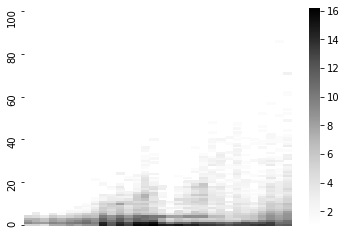

In [3]:
plt = sns.heatmap(cnts, cmap='Greys', mask=(cnts==0), xticklabels=False, yticklabels=20)
plt.invert_yaxis()

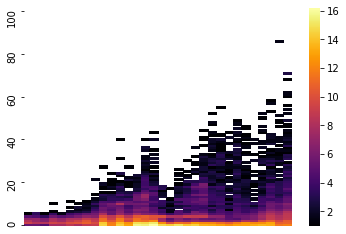

In [4]:
plt = sns.heatmap(cnts, cmap='inferno', mask=(cnts==0), xticklabels=False, yticklabels=20)
plt.invert_yaxis()

# Datashader
To answer question 2, I first created a new column for the data which listed building assessment (just total minus land). I then setup a few color sequences to experiment with different colors in a bivariate choropleth.

After initializing all of this, I decided to get a small look at the data by creating two plots, one for land assessment and one for building assessment.

In [ ]:
!pip install datashader
import datashader as ds
import datashader.transfer_functions as tf
from datashader import reductions

#from functools import partial
#from datashader.utils import export_image
#export = partial(export_image, background = background, export_path="export")

nyc['assessbuilding'] = nyc['assesstot']-nyc['assessland']

reds = ["#000000", "#190000", "#320000", "#4B0000", "#640000", "#7D0000", "#960000", "#AF0000", "#C80000", "#E10000", "#FF0000"]
greens = ["#000000", "#001900", "#003200", "#004B00", "#006400", "#007D00", "#009600", "#00AF00", "#00C800", "#00E100", "#00FF00"]
blues = ["#000000", "#000019", "#000032","#00004B", "#000064", "#00007D", "#000096", "#0000AF", "#0000C8", "#0000E1", "#0000FF"]

NewYorkCity = ((913164.0, 1067279.0), (120966.0, 272275.0))
small_cvs = ds.Canvas(500, 500, *NewYorkCity)

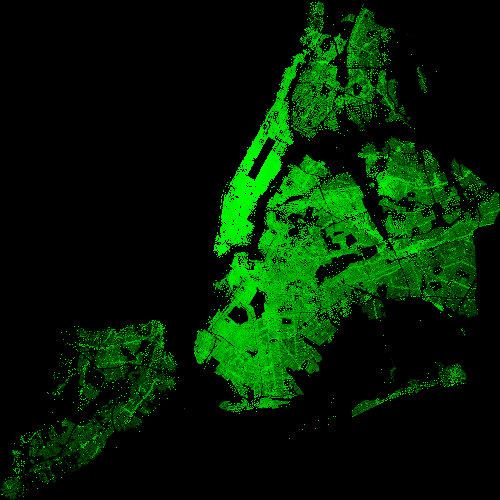

In [7]:
# Land value low to high - black to green
small_agg_land = small_cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessland'))
small_land_assess = tf.shade(small_agg_land, cmap = greens, how='eq_hist')

tf.set_background(small_land_assess, 'black')

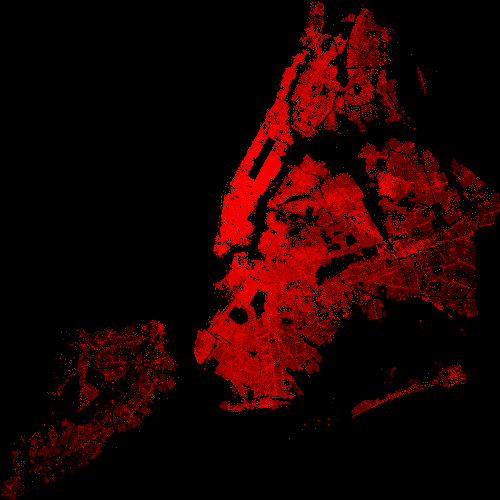

In [8]:
# Building value low to high - black to red
small_agg_building = small_cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessbuilding'))
small_building_assess = tf.shade(small_agg_building, cmap = reds, how='eq_hist')

tf.set_background(small_building_assess, 'black')

# Question 2
After getting a little bit of insight into the assessment of property throughout NYC, I created a bivariate choropleth map to show neighborhoods of interest for real estate development. Assuming the principle stated in the HW (more valuable buildings should be built on more valuable lots), a developer should choose to build in the green areas of the map below and avoid the red areas. Green corresponds to high assessment of land, but low assessment of structures, while red corresponds to the opposite. Yellow corresponds to high assessments on both and black to low assessments (or no assessment) on both.

In aggragating the data, I used the sum feature for each pixel. I chose sum because I assumed that some pixels may contain multiple lots, where the mean would misrepresent the value of a larger building that spanned multiple lots (as often happens in midtown).

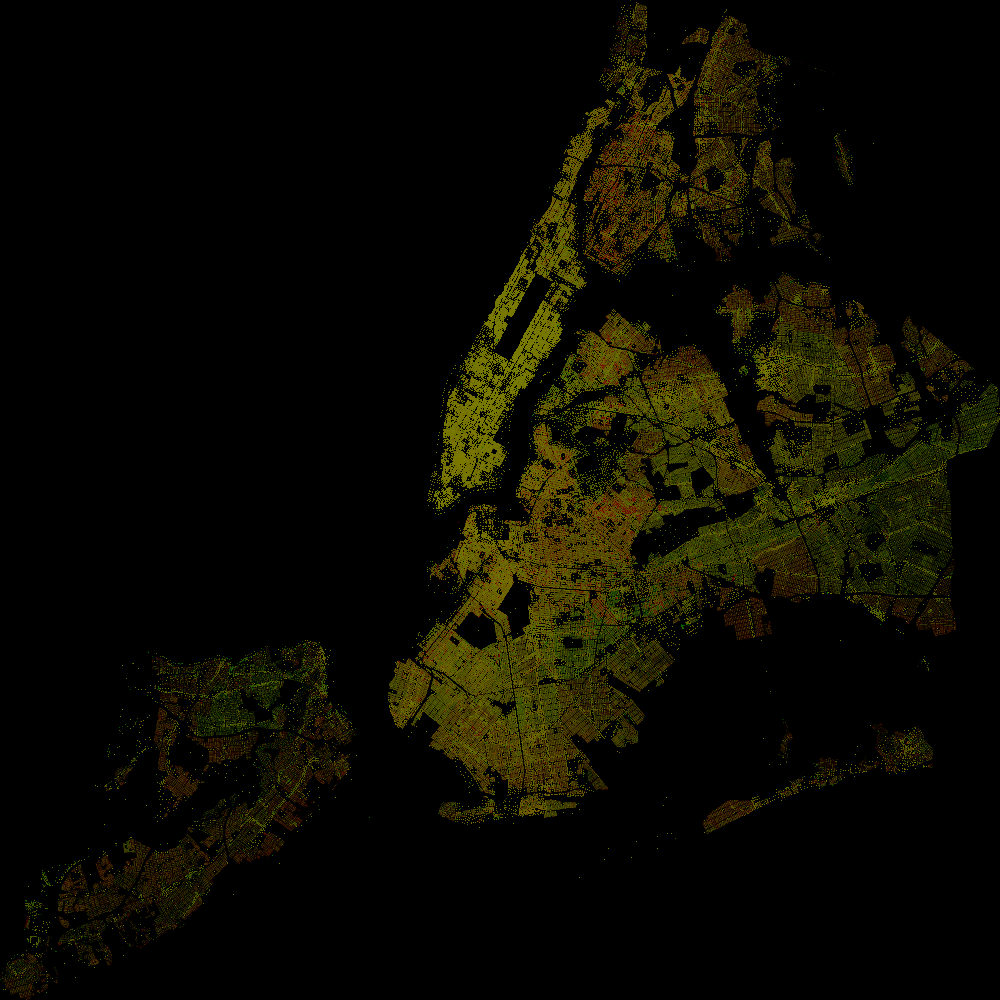

In [9]:
cvs = ds.Canvas(1000, 1000, *NewYorkCity)

agg_land = cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessland'))
land_assess = tf.shade(agg_land, cmap = greens, alpha = 127, how='eq_hist')

agg_building = cvs.points(nyc, 'xcoord', 'ycoord', agg = reductions.sum('assessbuilding'))
building_assess = tf.shade(agg_building, cmap = reds, alpha = 127, how='eq_hist')

tf.set_background(tf.stack(building_assess, land_assess, how = 'add'),'black')